# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

--- LABELS---
label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
batch#: 1
Label distribution: number: 10000  min: 0 max: 9 mean: 4.4983 std: 2.87224600444
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
batch#: 2
Label distribution: number: 10000  min: 0 max: 9 mean: 4.4983 std: 2.86408748295
Label Counts: {0: 984, 1: 1007, 2: 1010, 3: 995, 4: 1010, 5: 988, 6: 1008, 7: 1026, 8: 987, 9: 985}
batch#: 3
Label distribution: number: 10000  min: 0 max: 9 mean: 4.499 std: 2.87795048602
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
batch#: 4
Label distribution: number: 10000  min: 0 max: 9 mean: 4.5024 std: 2.86628579175
Label Counts: {0: 1003, 1: 963, 2: 1041, 3: 976, 4: 1004, 5: 1021, 6: 1004, 7: 981, 8: 1024, 9: 983}
batch#: 5
Label distribution: number: 10000  min: 0 max: 9 mean: 4.502 std: 2.88079780616
Label Counts: {0: 1014, 1: 1

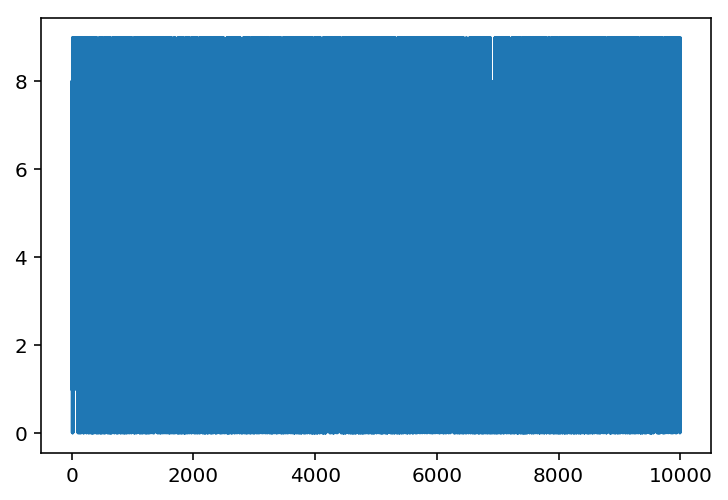

Image - Min Value: 1 Max Value: 255
Image - Shape: (32, 32, 3)


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
import matplotlib.pyplot as plt 

def dataExplorer(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    print ('--- LABELS---\nlabel names:',helper._load_label_names())
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    for b in batch_ids:
        print('batch#:', b)
        features, labels = helper.load_cfar10_batch(cifar10_dataset_folder_path, b)
        print ('Label distribution: number:',len(labels),' min:', np.min(labels), 'max:', np.max(labels), 'mean:', np.mean(labels), 'std:',np.std(labels))
        print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))

    plt.plot(list(range(10000)),labels)
    plt.show()

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))

# Explore the dataset
batch_id = 1
sample_id = 5
#helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)
dataExplorer(cifar10_dataset_folder_path, batch_id, sample_id)

### Data Understanding

- __Labels and batches__:<br>
5 batches,  10 different labels:<br>
'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
- __Label distribution__: <br>
Mean and std are in the same area for all 5 batches, even if the number of instances of one label differ a bit between the batches. The example plot shows that we have all labels randomly distributes over the batch.<br>

- __Images__:
Images have the shape (32,32,3), so we have 3 color channels, all with a range from 1 to 255.


## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `x`.

In [3]:
def norm(x):
    return (x)/255.0
norm=np.vectorize(norm)
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return norm(x)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot encode
Just like the previous code cell, you'll be implementing a function for preprocessing.  This time, you'll implement the `one_hot_encode` function. The input, `x`, are a list of labels.  Implement the function to return the list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function should return the same encoding for each value between each call to `one_hot_encode`.  Make sure to save the map of encodings outside the function.

**Hint:**

Look into LabelBinarizer in the preprocessing module of sklearn.

In [4]:
from sklearn import preprocessing

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function

    classes=list(range(10))
    lb = preprocessing.LabelBinarizer()
    lb=lb.fit(classes)
    result=np.array(lb.transform(x))
    return result


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


#### Question to the reviewer:
Above it is mentioned "Make sure to save the map of encodings outside the function." - what is intended? 
As the interface does not pass an identifier, i.e. the batchId, I have little option to cache it. <br>
Would you mind to explain in detail?

### Randomize Data
As you saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but you don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)
print('done')

done


# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
print('done')

done


## Build the network
For the neural network, you'll build each layer into a function.  Most of the code you've seen has been outside of functions. To test your code more thoroughly, we require that you put each layer in a function.  This allows us to give you better feedback and test for simple mistakes using our unittests before you submit your project.

>**Note:** If you're finding it hard to dedicate enough time for this course each week, we've provided a small shortcut to this part of the project. In the next couple of problems, you'll have the option to use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages to build each layer, except the layers you build in the "Convolutional and Max Pooling Layer" section.  TF Layers is similar to Keras's and TFLearn's abstraction to layers, so it's easy to pickup.

>However, if you would like to get the most out of this course, try to solve all the problems _without_ using anything from the TF Layers packages. You **can** still use classes from other packages that happen to have the same name as ones you find in TF Layers! For example, instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), you would want to use the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    result= tf.placeholder(tf.float32,\
                   shape=(None , #batch_size\
                          image_shape[0], #image_height\
                          image_shape[1], #image_width \
                          image_shape[2]   #num_channels\
                          ),name='x')
    ##print (image_shape, result.shape)
    return result


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    result = tf.placeholder(tf.float32, \
                            shape=(None , #batch_size\
                                   n_classes #number of classes\
                                   ),name='y')
    return result


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    result = tf.placeholder(tf.float32, shape=None, name='keep_prob')
    return result


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.

**Note:** You **can't** use [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) for **this** layer, but you can still use TensorFlow's [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) package. You may still use the shortcut option for all the **other** layers.

** Hint: **

When unpacking values as an argument in Python, look into the [unpacking](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists) operator. 

In [8]:
paddingConv='SAME'
paddingPooling=paddingConv

def tupel2Array(a):
    return [1,a[0],a[1],1]

def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    matrixShape=[conv_ksize[0], conv_ksize[1],int(x_tensor.shape[3]),conv_num_outputs]
    weights = tf.Variable(tf.truncated_normal(shape=matrixShape, stddev=0.1))
    biases = tf.Variable(tf.zeros([conv_num_outputs]))
    
    y_tensor = tf.nn.conv2d(x_tensor, weights, tupel2Array(conv_strides), padding=paddingConv)
    y_tensor = tf.nn.relu(y_tensor + biases)
    y_tensor = tf.nn.max_pool(y_tensor, tupel2Array(pool_ksize), tupel2Array(pool_strides), padding=paddingPooling)

    
    if False:
        print ('in :\n tensor shape:{}\n conv_ksize: {},conv_strides: {},conv_num_outputs: {} '.format(x_tensor.shape,conv_ksize,conv_strides, conv_num_outputs))
        print (' pool_ksize: {}'.format(pool_ksize))
        print ('out:\n tensor shape:{}'.format(y_tensor.shape) )
    return y_tensor 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

Tests Passed


#### Question to reviewer:
from testing:
<pre><code>
in :
 tensor shape:(?, 32, 32, 5)
 conv_ksize: (2, 2),conv_strides: (4, 4),conv_num_outputs: 10 
 pool_ksize: (2, 2)
out:
 tensor shape:(?, 4, 4, 10)</code></pre>

I'm astonished about the test parametrisation:<br>
Image input: 32\*32<br>
patch size for convolution layer: 2\*2, stride size: 4\*4:<br>
Is this reasonable? this means  - in one dimension:<br>
pixel[0,1]: used, pixel[2,3]: ignored, and so on?

### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    shape = x_tensor.get_shape().as_list()
    y_tensor = tf.reshape(x_tensor,[-1, shape[1]*shape[2]*shape[3]])

    return y_tensor


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [10]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    shape = x_tensor.get_shape().as_list()
    weights = tf.Variable(tf.truncated_normal([shape[1], num_outputs], stddev=0.1))
    biases = tf.Variable(tf.constant(1.0, shape=[num_outputs]))
    
    y_tensor = tf.nn.relu(tf.matmul(x_tensor, weights) + biases)
    
    return y_tensor


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    shape = x_tensor.get_shape().as_list()
    weights = tf.Variable(tf.truncated_normal([shape[1], num_outputs], stddev=0.1))
    biases = tf.Variable(tf.constant(1.0, shape=[num_outputs]))
    
    # before review: y_tensor = tf.nn.relu(tf.matmul(x_tensor, weights) + biases)
    y_tensor = tf.matmul(x_tensor, weights) + biases
    return y_tensor


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [113]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    # convolution
    # Layer 1: convolution: patch: 5*5, stride: 2*2, dropout: n/a for the moment=> result(-1, 16*16*16)
    # Layer 2: convolution: patch: 5*5, stride: 2*2, dropout: n/a for the moment=> result(-1, 8*8*16)
    # Layer 3: convolution: patch: 5*5, stride: 2*2, dropout: n/a for the moment=> result(-1, 4*4*16)
    outp_conv= conv2d_maxpool(x, 16, (3,3), (1,1), (1,1), (1,1))
    outp_conv= conv2d_maxpool(outp_conv, 16, (3,3), (1,1), (2,2), (2,2))
    outp_conv= conv2d_maxpool(outp_conv, 16, (3,3), (1,1), (1,1), (1,1))
    outp_conv= conv2d_maxpool(outp_conv, 16, (5,5), (1,1), (2,2), (2,2))
   
    ##print ('shape: conv_3: ', outp_conv.shape)


    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    outp_flatten=flatten(outp_conv)
    outp_flatten = tf.nn.dropout(outp_flatten, keep_prob)
    ##print ('shape: flatten: ', outp_flatten.shape)
    

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    outp_fully = fully_conn(outp_flatten, 64)
    outp_fully = fully_conn(outp_fully, 64)
    outp_fully = fully_conn(outp_fully, 64)
    ## print ('shape: fully 3: ', outp_fully.shape)
    
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    result= output(outp_fully, 10)
    
    
    # TODO: return output
    return result


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization
Implement the function `train_neural_network` to do a single optimization.  The optimization should use `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function will be called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [109]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    image_shape=feature_batch.shape[1:4]
    plcHolder_images = neural_net_image_input(image_shape)
    plcHolder_labels = neural_net_label_input(10)
    feed_dict = {x : feature_batch, y : label_batch, keep_prob:keep_probability}
    #_, cost2, predictions = session.run(
    result = session.run(
      [optimizer, cost, correct_pred], feed_dict=feed_dict)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [110]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    feed_dict = {x : feature_batch, y : label_batch, keep_prob:1.0}

    c,a = sess.run([cost,accuracy],feed_dict=feed_dict)
    
    valid_feed_dict = {x : valid_features, y : valid_labels, keep_prob:1.0}
    v = sess.run (accuracy, feed_dict=valid_feed_dict)

    print ('training: cost:%.2f accuracy: %.2f validation: accuracy: %.2f'% (c,a,v))
 

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [116]:
# TODO: Tune Parameters
epochs = 30
batch_size = 2048
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, run the model on all the data in the next section.

In [117]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)
        
print ('done')

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  training: cost:2.32 accuracy: 0.12 validation: accuracy: 0.10
Epoch  2, CIFAR-10 Batch 1:  training: cost:2.31 accuracy: 0.14 validation: accuracy: 0.13
Epoch  3, CIFAR-10 Batch 1:  training: cost:2.28 accuracy: 0.14 validation: accuracy: 0.13
Epoch  4, CIFAR-10 Batch 1:  training: cost:2.23 accuracy: 0.23 validation: accuracy: 0.20
Epoch  5, CIFAR-10 Batch 1:  training: cost:2.16 accuracy: 0.27 validation: accuracy: 0.24
Epoch  6, CIFAR-10 Batch 1:  training: cost:2.07 accuracy: 0.26 validation: accuracy: 0.25
Epoch  7, CIFAR-10 Batch 1:  training: cost:1.99 accuracy: 0.27 validation: accuracy: 0.27
Epoch  8, CIFAR-10 Batch 1:  training: cost:1.93 accuracy: 0.29 validation: accuracy: 0.29
Epoch  9, CIFAR-10 Batch 1:  training: cost:1.88 accuracy: 0.30 validation: accuracy: 0.31
Epoch 10, CIFAR-10 Batch 1:  training: cost:1.83 accuracy: 0.32 validation: accuracy: 0.33
Epoch 11, CIFAR-10 Batch 1:  training: cost:1.7

#### Log over the different model after changes of review:
- initial model:<br>
epoch: 20<br>
conv: 3 layers, patch: 5\*5, stride:2\*2, maxpooling: 1\*1, output depth: 16<br>
dropout: keep_prob=0.50 between conv1/2<br>
fully: 3 layers, depth: 64 => **accuracy: 0.38, 30 ep: 0.45 **<br>

- variations:<br>
-- dropout =1.0 => ** accuracy: 0.43 **<br>
-- dropout between fully1/2, prob=0.5=> ** accuracy: 0.37 **<br>
-- conv: 4 layers, stride 1\*1, dropout between fully1/2, prob=0.5=> ** accuracy: 0.37 **<br>
-- back to initial, dropout behind flatten prob=0.5=> ** accuracy: 0.37 **<br>
-- back to initial, dropout behind flatten prob=0.5, fully: 4=> ** accuracy: 0.37 **<br>
-- conv:4 layers, patch 3\*3=>** accuracy: 20 Ep: 0.36 **<br>
-- conv: 4 layers: patch 2 \*(3\*3), 2\*(5\*5)=>** accuracy: 20 Ep: 0.35 **<br>
-- conv: 4 layers: patch 3,4,5,6=>** accuracy: 20 Ep: 0.38 **<br>
-- conv: 4 layers: patch 3,4,5,6, dropout between flatten/fully: 0.5=>** accuracy: 20 Ep: 0.35 **<br>
-- conv: 4 layers: patch 3,3,5,7, dropout between flatten/fully: 1.0=>** accuracy: 20 Ep: 0.38 30 EP: 0.42**<br>
-- conv: 4 l, patch: 4\*(3,3), strides: 2*(1,1), 2*(2,2)=>** accuracy: 20 Ep: 0.42, 30 EP: 0.46**<br>
-- conv: 4 l, patch: 4\*(3,3), strides: 4\*(1,1), maxpool after 2 and 4=>** accuracy: 20 Ep: 0.41, 30 EP: 0.46** <br>
-- as before with dropout 0.5=>** accuracy: 20 Ep: 0.44, 30 EP: 0.47**<br>
++ conv: 4 l, patch: 3\*(3,3),(5,5), strides: 4\*(1,1), maxpool after 2 and 4, dropO: 0.5=>** accuracy: 20 Ep: 45/33, 30 EP: 0.49/47 <br>
-- conv: 4 l, patch: 3\*(3,3),(5,5), strides: 4\*(1,1), maxpool after 2 and 4, dropO: 1.0=>** accuracy: 20 Ep: 41, 30 EP: 0.49 <br>

#### Log over the different models:
- Epoch: seems to be stable around 8 or 9 => keep it on 10 for the moment
- **initial model** :<br>
epoch: 10<br>
conv: 3 layers, patch: 5\*5, stride:2\*2, maxpooling: 1\*1, output depth: 16<br>
dropout: keep_prob=1.0<br>
fully: 3 layers, depth: 64 => **accuracy: 0.6/0.575 **
- **tries - dropout between conv and fully**:<br>
dropout 0.5=> **accuracy: 0.575 (10 Ep), 0.6 (20 Ep)** => no improvement<br>
dropout: 0.5, conv: patch: 4\*4, 20 Ep => **accuracy: 0.5 **=> no improvement<br>
dropout: 1.0, conv: patch: 6\*6 => **acc: 10 Ep: 0.57, 20 Ep: 0.8**<br>
dropout: 0.5, conv: patch: 6\*6 => **acc: 20 Ep: 0.6**<br>
dropout: 0.5, conv: patch: 5\*5, stride: 1\*1, maxp: 2\*2 => **acc: 20 Ep: 0.47**
- **tries - moving dropout**:<br>
dropout between conv1/2: 0.5, back to initial config =>**acc: 20 Ep: 0.7, 0.5 reached at Ep 5 **<br>
dropout between conv1/2 + conv2/conv3: 0.5, back to initial config =>**acc: 20 Ep: 0.6, 0.5 reached at Ep 10 **<br>
dropout between conv2/3: 0.5, back to initial config =>**acc: 20 Ep: 0.5, 0.5 reached at Ep 14<br>
dropout between conv1/2 and conv3/flatten: 0.5, back to initial config =>**acc: 20 Ep: 0.5, 0.5 reached at Ep 16<br>
dropout between conv1/2 and fully1/2: 0.5, back to initial config =>**acc: 20 Ep: 0.5, 0.5 reached at Ep 19<br>

##### => initial model with dropout between conv1/v2, because it is a fast learner

### Fully Train the Model
Now that you got a good accuracy with a single CIFAR-10 batch, try it with all five batches.

In [118]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)
    

Training...
Epoch  1, CIFAR-10 Batch 1:  training: cost:2.30 accuracy: 0.13 validation: accuracy: 0.13
Epoch  1, CIFAR-10 Batch 2:  training: cost:2.27 accuracy: 0.15 validation: accuracy: 0.16
Epoch  1, CIFAR-10 Batch 3:  training: cost:2.20 accuracy: 0.16 validation: accuracy: 0.19
Epoch  1, CIFAR-10 Batch 4:  training: cost:2.12 accuracy: 0.21 validation: accuracy: 0.21
Epoch  1, CIFAR-10 Batch 5:  training: cost:2.04 accuracy: 0.26 validation: accuracy: 0.24
Epoch  2, CIFAR-10 Batch 1:  training: cost:2.04 accuracy: 0.26 validation: accuracy: 0.27
Epoch  2, CIFAR-10 Batch 2:  training: cost:1.96 accuracy: 0.29 validation: accuracy: 0.29
Epoch  2, CIFAR-10 Batch 3:  training: cost:1.87 accuracy: 0.31 validation: accuracy: 0.29
Epoch  2, CIFAR-10 Batch 4:  training: cost:1.85 accuracy: 0.33 validation: accuracy: 0.31
Epoch  2, CIFAR-10 Batch 5:  training: cost:1.80 accuracy: 0.31 validation: accuracy: 0.33
Epoch  3, CIFAR-10 Batch 1:  training: cost:1.81 accuracy: 0.36 validation: ac

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

Testing Accuracy: 0.6342315435409546



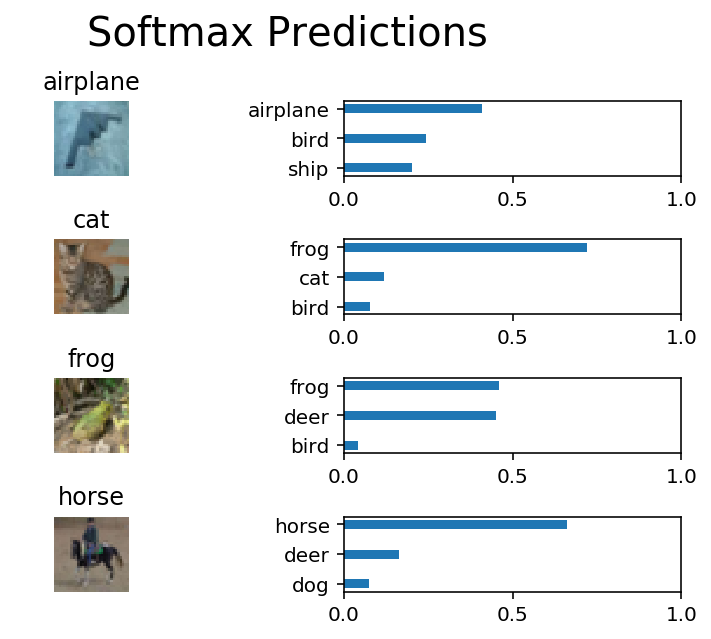

In [121]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why you can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. That's because there are many more techniques that can be applied to your model and we recemmond that once you are done with this project, you explore!

## Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook.  Save the notebook file as "image_classification.ipynb" and save it as a HTML file under "File" -> "Download as".  Include the "helper.py" and "problem_unittests.py" files in your submission.